# Introduction to Time Series Forecasting
## Regression and LSTMs

For a more detailed breakdown of the theory behind the code, check out the [full article](https://blog.paperspace.com/time-series-forecasting-regression-and-lstm/) on the Paperspace blog.

In [20]:
## Already installed on this container
# !pip install statsmodels

In [2]:
import pandas as pd

df = pd.read_csv('jena_climate_2009_2016.csv')

time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
series = df['T (degC)'][5::6]
series.index = time[5::6]

In [3]:
import numpy as np

# function for generating the lagged matrix
def split_sequence(sequence, window_size):
    X = []
    y = []
    # for all indexes
    for i in range(len(sequence)):
        end_idx = i + window_size
        # exit condition
        if end_idx > len(sequence) - 1:
            break
        # get X and Y values
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


train = series[:-int(len(series)/10)]
test = series[-int(len(series)/10):]
X_train, y_train = split_sequence(train, window_size=24)
X_test, y_test = split_sequence(test, window_size=24)

In [4]:
import statsmodels.api as sm

# train Ordinary Least Squares model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.376e+05
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:46:03   Log-Likelihood:                -70605.
No. Observations:               63058   AIC:                         1.413e+05
Df Residuals:                   63033   BIC:                         1.415e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0317      0.005      6.986      0.0

In [5]:
from scipy import stats

# get values of the residuals
residual = result.resid

# run tests and get the p values
print('p value of Jarque-Bera test is: ', stats.jarque_bera(residual)[1])
print('p value of Shapiro-Wilk test is: ', stats.shapiro(residual)[1])
print('p value of Kolmogorov-Smirnov test is: ', stats.kstest(residual, 'norm')[1])

p value of Jarque-Bera test is:  0.0
p value of Shapiro-Wilk test is:  0.0
p value of Kolmogorov-Smirnov test is:  0.0


/opt/conda/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [6]:
import statsmodels.stats.api as sms

print('p value of Breusch–Pagan test is: ', sms.het_breuschpagan(result.resid, result.model.exog)[1])
print('p value of White test is: ', sms.het_white(result.resid, result.model.exog)[1])

p value of Breusch–Pagan test is:  2.996182722643564e-246
p value of White test is:  0.0


In [7]:
# train Generalised Least Squares model
X_train = sm.add_constant(X_train)
model = sm.GLS(y_train, X_train)
result = model.fit()

print(result.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            GLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.376e+05
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:46:14   Log-Likelihood:                -70605.
No. Observations:               63058   AIC:                         1.413e+05
Df Residuals:                   63033   BIC:                         1.415e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0317      0.005      6.986      0.0

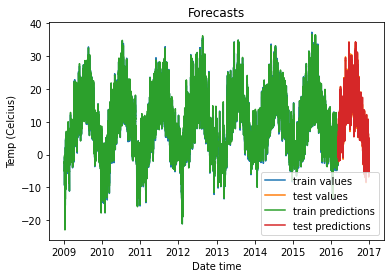

In [8]:
X_test = sm.add_constant(X_test)

y_train_preds = result.predict(X_train)
y_test_preds = result.predict(X_test)

from matplotlib import pyplot as plt

# indexes start from 24 due to the window size we chose
plt.plot(pd.Series(y_train, index=train[24:].index), label='train values')
plt.plot(pd.Series(y_test, index=test[24:].index), label='test values')
plt.plot(pd.Series(y_train_preds, index=train[24:].index), label='train predictions')
plt.plot(pd.Series(y_test_preds, index=test[24:].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Forecasts')
plt.legend()
plt.show()

In [9]:
# train test split
train = series[:-int(len(series)/10)]
train_idx = train.index
test = series[-int(len(series)/10):]
test_idx = test.index

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = pd.Series(scaler.fit_transform(train.values.reshape(-1, 1))[:, 0], index=train_idx)
test = pd.Series(scaler.transform(test.values.reshape(-1, 1))[:, 0], index=test_idx)

In [11]:
window_size = 24

X_train, y_train = split_sequence(train, window_size=window_size)
X_test, y_test = split_sequence(test, window_size=window_size)

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader


# convert train and test data to tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

# use torch tensor datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# get data loaders
batch_size = 32
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


In [13]:
from torch import nn


class DenseLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers=1, bidirectional=False, dense=False):
        super(DenseLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layers = lstm_layers
        self.bidirectional = bidirectional
        self.dense = dense
        # define the LSTM layer
        self.lstm = nn.LSTM(input_size=self.input_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.layers,
                            bidirectional=self.bidirectional)
        self.act1 = nn.ReLU()
        # change linear layer inputs depending on if lstm is bidrectional
        if not bidirectional:
            self.linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        else:
            self.linear = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.act2 = nn.ReLU()
        # change linear layer inputs depending on if lstm is bidrectional and extra dense layer isn't added
        if bidirectional and not dense:
            self.final = nn.Linear(self.hidden_dim * 2, 1)
        else:
            self.final = nn.Linear(self.hidden_dim, 1)


    def forward(self, inputs, labels=None):
        out = inputs.unsqueeze(1)
        out, h = self.lstm(out)
        out = self.act1(out)
        if self.dense:
            out = self.linear(out)
            out = self.act2(out)
        out = self.final(out)
        return out


In [14]:
import time

def fit(model, optimizer, criterion):
    print("{:<8} {:<25} {:<25} {:<25}".format('Epoch', 
                                          'Train Loss', 
                                          'Test Loss', 
                                          'Time (seconds)'))
    for epoch in range(epochs):
        model.train()
        start = time.time()
        epoch_loss = []
        # for batch in train data
        for step, batch in enumerate(train_dataloader):
            # make gradient zero to avoid accumulation
            model.zero_grad()
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            # get predictions
            out = model(inputs)
            out.to(device)
            # get loss
            loss = criterion(out, labels)
            epoch_loss.append(loss.float().detach().cpu().numpy().mean())
            # backpropagate
            loss.backward()
            optimizer.step()
        test_epoch_loss = []
        end = time.time()
        model.eval()
        # for batch in validation data
        for step, batch in enumerate(test_dataloader):
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            # get predictions
            out = model(inputs)
            # get loss
            loss = criterion(out, labels)     
            test_epoch_loss.append(loss.float().detach().cpu().numpy().mean())
        print("{:<8} {:<25} {:<25} {:<25}".format(epoch+1, 
                                                  np.mean(epoch_loss), 
                                                  np.mean(test_epoch_loss), 
                                                  end-start))


In [15]:
device = torch.device(type='cuda')

hidden_dim = 32
epochs = 5

Epoch    Train Loss                Test Loss                 Time (seconds)           


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:447: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:447: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:447: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(in

1        0.986396849155426         0.603157639503479         8.659582138061523        
2        0.9863997101783752        0.6855114102363586        10.358625650405884       
3        0.9849903583526611        0.6173835396766663        9.561526536941528        
4        0.9834603667259216        0.640491783618927         6.6650238037109375       
5        0.983932614326477         0.6320008039474487        6.230933427810669        


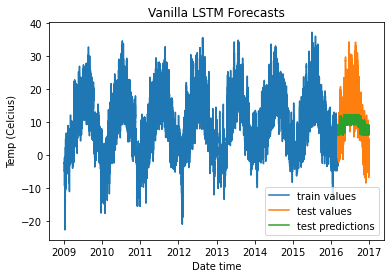

In [16]:
# vanilla LSTM
model = DenseLSTM(window_size, hidden_dim, lstm_layers=1, bidirectional=False, dense=False)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Vanilla LSTM Forecasts')
plt.legend()
plt.show()

Epoch    Train Loss                Test Loss                 Time (seconds)           
1        0.9869848489761353        0.6642616391181946        8.76820182800293         
2        0.9850104451179504        0.6796317100524902        8.789787769317627        
3        0.9853472709655762        0.632046103477478         8.75286340713501         
4        0.98580402135849          0.62270587682724          8.678250074386597        
5        0.9856237769126892        0.6542365550994873        8.82204556465149         


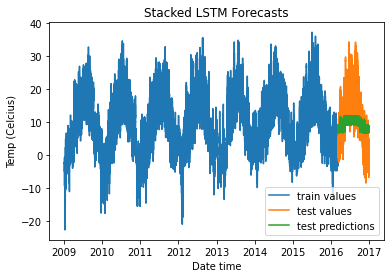

In [17]:
# Stacked LSTM
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=False, dense=False)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Stacked LSTM Forecasts')
plt.legend()
plt.show()

Epoch    Train Loss                Test Loss                 Time (seconds)           
1        0.9742112755775452        0.37319594621658325       13.66820216178894        
2        0.9707732796669006        0.4101688265800476        13.566223859786987       
3        0.9679632186889648        0.37282949686050415       13.950774192810059       
4        0.9707273244857788        0.3504370450973511        15.439115047454834       
5        0.9689825177192688        0.4031996428966522        14.517802715301514       


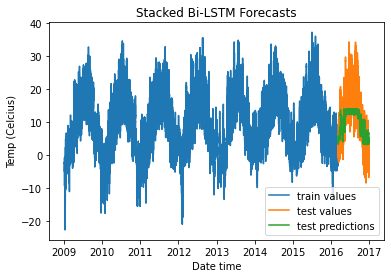

In [18]:
# Stacked bidirectional LSTM
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=True, dense=False)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Stacked Bi-LSTM Forecasts')
plt.legend()
plt.show()

Epoch    Train Loss                Test Loss                 Time (seconds)           
1        0.9731414318084717        0.4022016227245331        15.538724184036255       
2        0.9686041474342346        0.4012516736984253        20.030942678451538       
3        0.9695923924446106        0.4101630747318268        21.617289066314697       
4        0.9704879522323608        0.35339292883872986       20.62640619277954        
5        0.9699056148529053        0.3704677224159241        14.668129205703735       


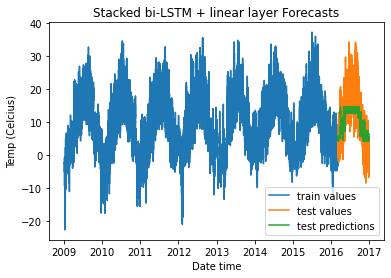

In [19]:
# Stacked bidirectional LSTM plus a linear layer
model = DenseLSTM(window_size, hidden_dim, lstm_layers=2, bidirectional=True, dense=True)
model.to(device)

# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# initate training
fit(model, optimizer, criterion)

# get predictions on validation set
model.eval()
preds = []
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    out = model(inputs)
    preds.append(out)

preds = [x.float().detach().cpu().numpy() for x in preds]
preds = np.array([y for x in preds for y in x])

# plot data and predictions and applying inverse scaling on the data
plt.plot(pd.Series(scaler.inverse_transform(y_train.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=train[window_size:].index), label='train values')
plt.plot(pd.Series(scaler.inverse_transform(y_test.float().detach().cpu().numpy().reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test values')
plt.plot(pd.Series(scaler.inverse_transform(preds.reshape(-1, 1))[:, 0], index=test[:-window_size].index), label='test predictions')
plt.xlabel('Date time')
plt.ylabel('Temp (Celcius)')
plt.title('Stacked bi-LSTM + linear layer Forecasts')
plt.legend()
plt.show()